In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 200

ng =10

ng_refs = (/ 2 , 2 , 6 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 340

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /0.75 , 0.75 , 0.8 , 0.8,
     &     0.75 , 0.7 , 0.5 , 0.6,
     &     0.75 , 0.65/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

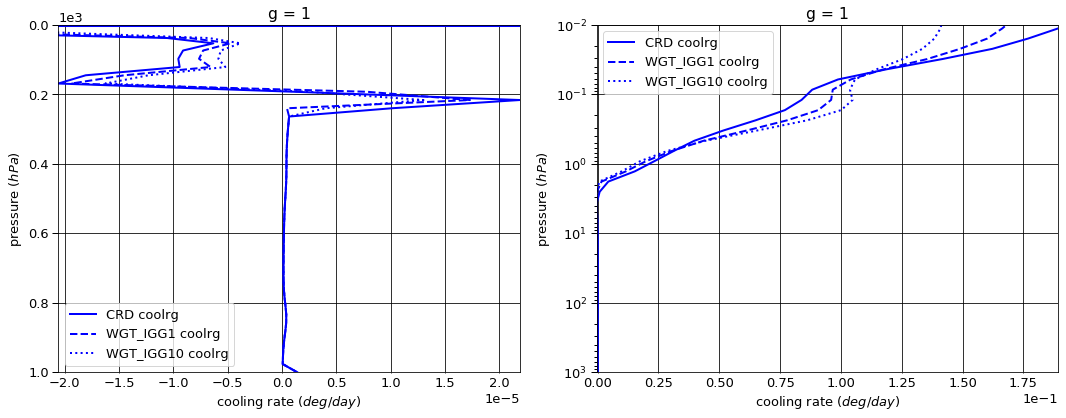

# Figure: cooling rate g-group 2

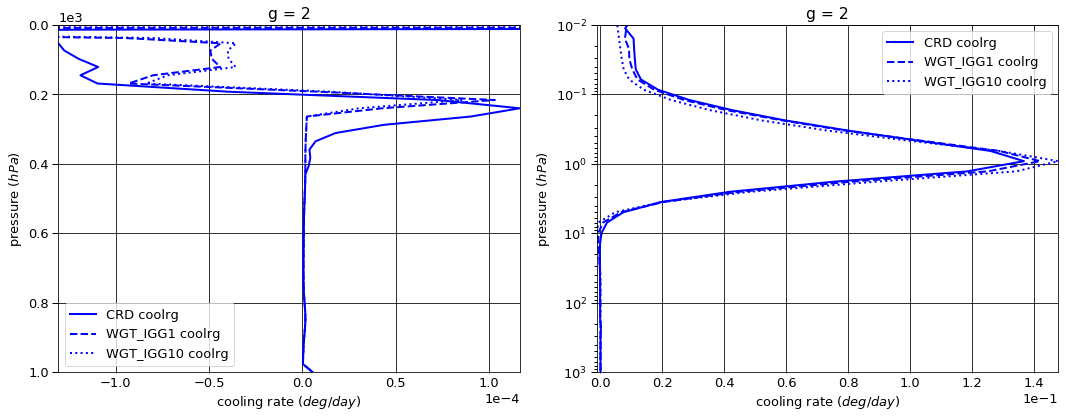

# Figure: cooling rate g-group 3

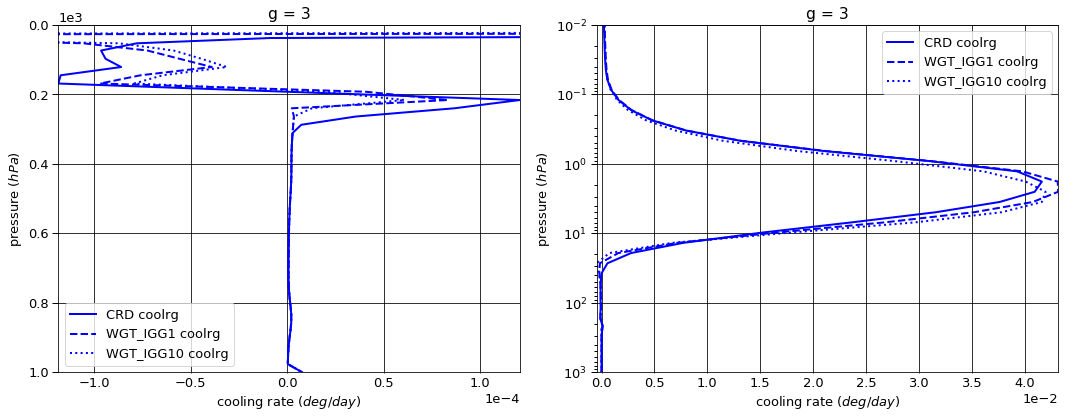

# Figure: cooling rate g-group 4

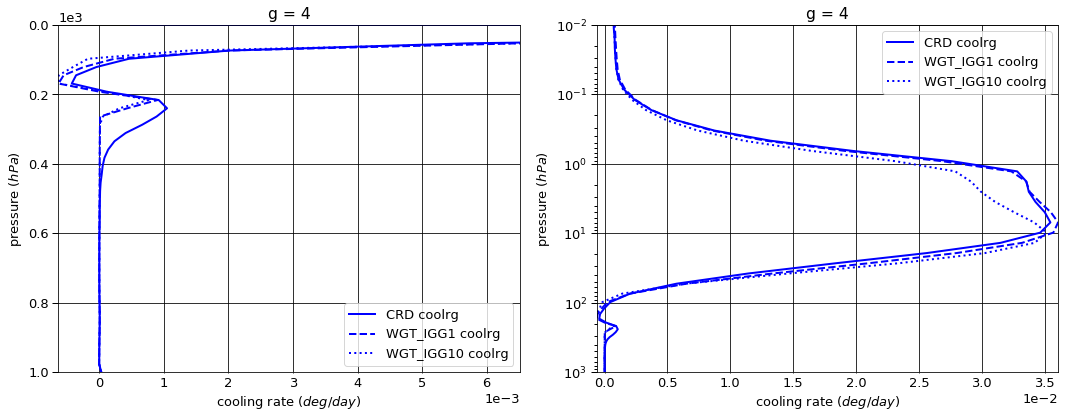

# Figure: cooling rate g-group 5

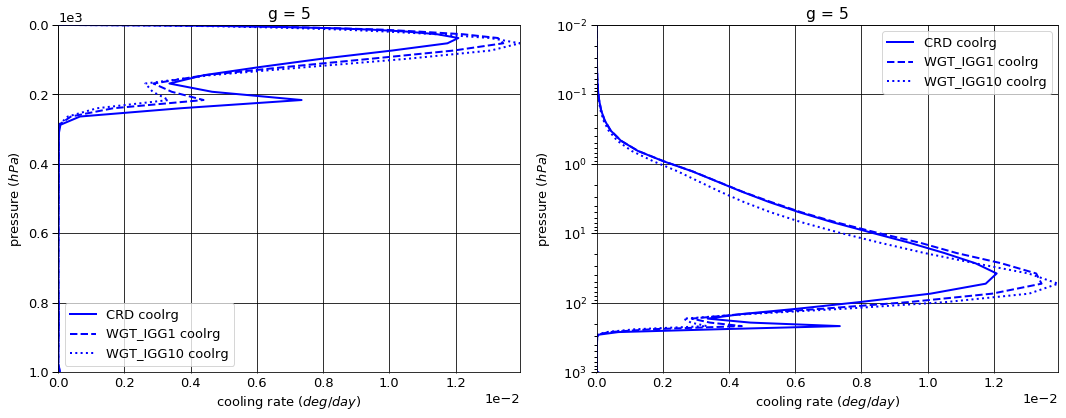

# Figure: cooling rate g-group 6

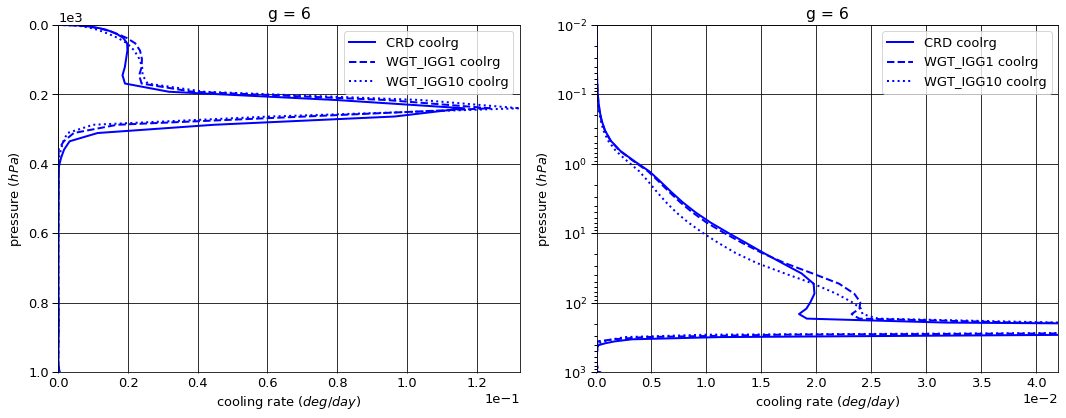

# Figure: cooling rate g-group 7

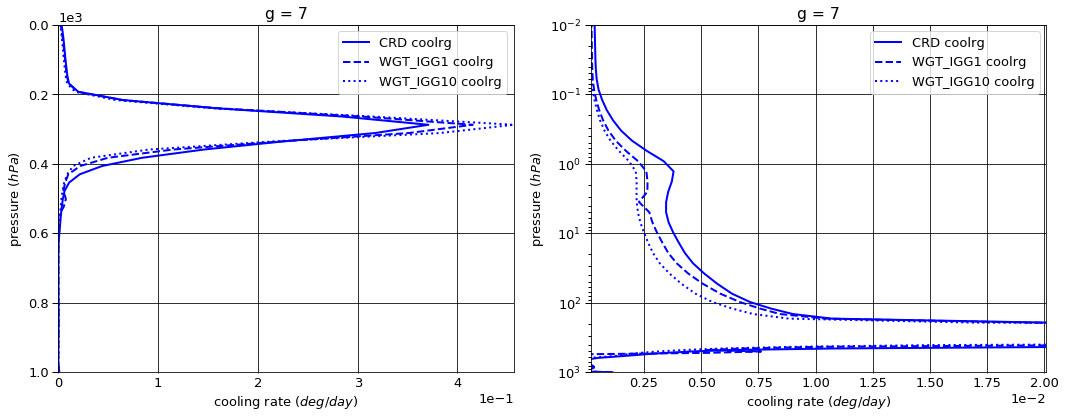

# Figure: cooling rate g-group 8

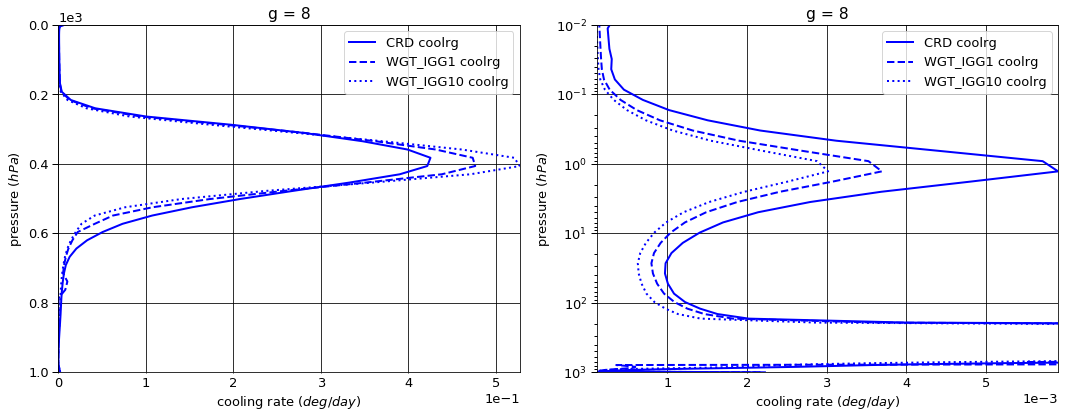

# Figure: cooling rate g-group 9

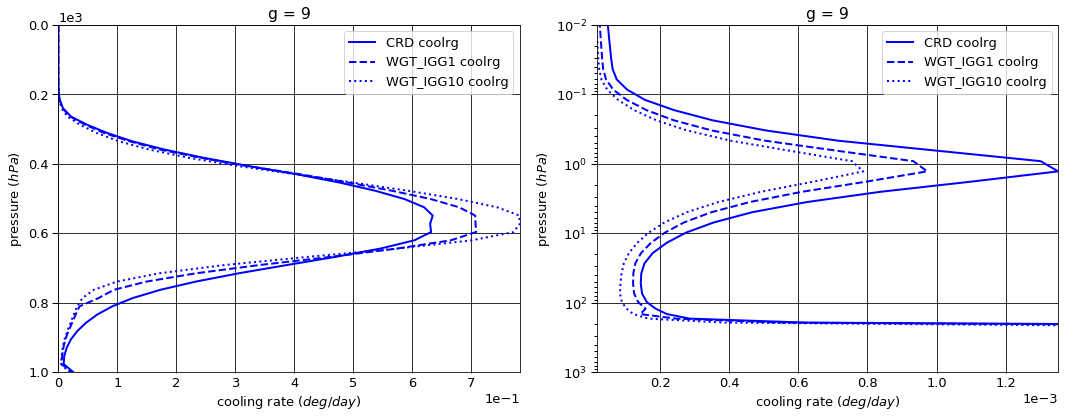

# Figure: cooling rate g-group 10

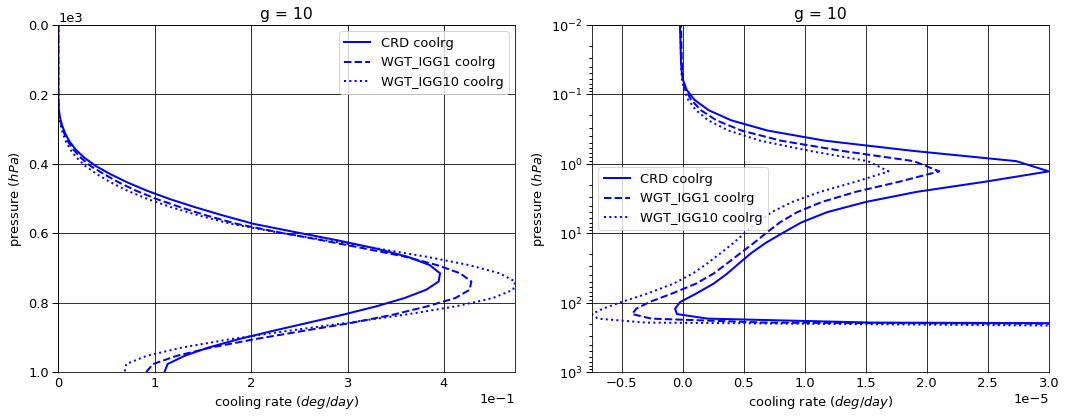

# Figure: cooling rate g-group total

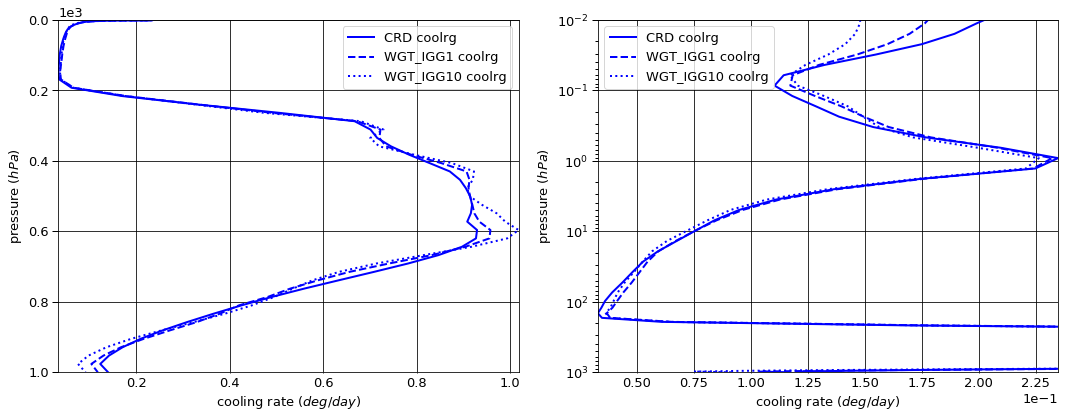

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.006920   0.000000  -0.006920
   1013.0   76     -0.011469   0.011465  -0.000004
2  0.0      1      -0.031230   0.000000  -0.031230
   1013.0   76     -0.042295   0.042279  -0.000015
3  0.0      1      -0.041330   0.000000  -0.041330
   1013.0   76     -0.062875   0.062854  -0.000022
4  0.0      1      -0.148463   0.000000  -0.148463
   1013.0   76     -0.273751   0.273655  -0.000096
5  0.0      1      -0.213567   0.000000  -0.213567
   1013.0   76     -0.428591   0.428449  -0.000142
6  0.0      1      -1.483736   0.000000  -1.483736
   1013.0   76     -2.917730   2.916711  -0.001019
7  0.0      1      -5.150715   0.000000  -5.150715
   1013.0   76     -8.892319   8.889220  -0.003099
8  0.0      1     -11.095159   0.000000 -11.095159
   1013.0   76    -16.773507  16.767430  -0.006076
9  0.0      1     -24.642797   0.000000 -24.642797
   1013.0   76    -32.405981  32.332728  -0.073253
10 0.0      1     -17.500894   0.000000 -17.500894
   1013.0   76    -20.507278  19.632284  -0.874994


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.006728   0.000000  -0.006728
   1013.0   76     -0.011469   0.011465  -0.000004
2  0.0      1      -0.031836   0.000000  -0.031836
   1013.0   76     -0.042295   0.042279  -0.000015
3  0.0      1      -0.041995   0.000000  -0.041995
   1013.0   76     -0.062875   0.062854  -0.000022
4  0.0      1      -0.147815   0.000000  -0.147815
   1013.0   76     -0.273751   0.273655  -0.000096
5  0.0      1      -0.212256   0.000000  -0.212256
   1013.0   76     -0.428591   0.428449  -0.000142
6  0.0      1      -1.452570   0.000000  -1.452570
   1013.0   76     -2.917730   2.916711  -0.001019
7  0.0      1      -5.112842   0.000000  -5.112842
   1013.0   76     -8.892319   8.889220  -0.003099
8  0.0      1     -11.004790   0.000000 -11.004790
   1013.0   76    -16.773507  16.767496  -0.006011
9  0.0      1     -24.440856   0.000000 -24.440856
   1013.0   76    -32.405981  32.347073  -0.058908
10 0.0      1     -17.516795   0.000000 -17.516795
   1013.0   76    -20.507278  20.080988  -0.426290


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.006674   0.000000  -0.006674
   1013.0   76     -0.011469   0.011465  -0.000004
2  0.0      1      -0.032209   0.000000  -0.032209
   1013.0   76     -0.042295   0.042279  -0.000015
3  0.0      1      -0.042055   0.000000  -0.042055
   1013.0   76     -0.062875   0.062854  -0.000022
4  0.0      1      -0.147466   0.000000  -0.147466
   1013.0   76     -0.273751   0.273655  -0.000096
5  0.0      1      -0.211207   0.000000  -0.211207
   1013.0   76     -0.428591   0.428449  -0.000142
6  0.0      1      -1.447125   0.000000  -1.447125
   1013.0   76     -2.917730   2.916711  -0.001019
7  0.0      1      -5.106339   0.000000  -5.106339
   1013.0   76     -8.892319   8.889220  -0.003099
8  0.0      1     -10.987127   0.000000 -10.987127
   1013.0   76    -16.773507  16.767496  -0.006011
9  0.0      1     -24.417590   0.000000 -24.417590
   1013.0   76    -32.405981  32.357892  -0.048089
10 0.0      1     -17.512312   0.000000 -17.512312
   1013.0   76    -20.507278  20.230217  -0.277061


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                      
1  0.0      1      0.000192  0.000000e+00  1.917975e-04
   1013.0   76     0.000000 -1.734723e-18  8.470329e-22
2  0.0      1     -0.000606  0.000000e+00 -6.057160e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
3  0.0      1     -0.000665  0.000000e+00 -6.649770e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
4  0.0      1      0.000648  0.000000e+00  6.482500e-04
   1013.0   76     0.000000  0.000000e+00 -1.355253e-20
5  0.0      1      0.001311  0.000000e+00  1.311430e-03
   1013.0   76     0.000000  0.000000e+00 -2.710505e-20
6  0.0      1      0.031166  0.000000e+00  3.116590e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
7  0.0      1      0.037873  0.000000e+00  3.787340e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
8  0.0      1      0.090369  0.000000e+00  9.036900e-02
   1013.0   76     0.000000  6.600000e-05  6.581760e-05
9  0.0      1      0.201941  0.000000e+00  2.019410e-01
   1013.0   76     0.000000  1.434500e-02  1.434501e-02
10 0.0      1     -0.015901  0.000000e+00 -1.590100e-02
   1013.0   76     0.000000  4.487040e-01  4.487046e-01


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                      
1  0.0      1      0.000246  0.000000e+00  2.463229e-04
   1013.0   76     0.000000 -1.734723e-18  8.470329e-22
2  0.0      1     -0.000979  0.000000e+00 -9.787500e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
3  0.0      1     -0.000724  0.000000e+00 -7.241040e-04
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
4  0.0      1      0.000997  0.000000e+00  9.966300e-04
   1013.0   76     0.000000  0.000000e+00 -1.355253e-20
5  0.0      1      0.002360  0.000000e+00  2.360160e-03
   1013.0   76     0.000000  0.000000e+00 -2.710505e-20
6  0.0      1      0.036611  0.000000e+00  3.661150e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
7  0.0      1      0.044376  0.000000e+00  4.437640e-02
   1013.0   76     0.000000  0.000000e+00  0.000000e+00
8  0.0      1      0.108032  0.000000e+00  1.080320e-01
   1013.0   76     0.000000  6.600000e-05  6.581760e-05
9  0.0      1      0.225207  0.000000e+00  2.252070e-01
   1013.0   76     0.000000  2.516400e-02  2.516449e-02
10 0.0      1     -0.011418  0.000000e+00 -1.141800e-02
   1013.0   76     0.000000  5.979330e-01  5.979336e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      2.059069e-01
   1001.112500 75     1.405021e-06
2  0.000312    1      6.472078e-03
   1001.112500 75     5.525076e-06
3  0.000312    1      1.049311e-04
   1001.112500 75     7.807388e-06
4  0.000312    1      4.946904e-04
   1001.112500 75     3.458588e-05
5  0.000312    1      3.237349e-07
   1001.112500 75     5.144073e-05
6  0.000312    1      2.649008e-05
   1001.112500 75     3.681149e-04
7  0.000312    1      2.738161e-04
   1001.112500 75     1.119481e-03
8  0.000312    1      1.734339e-04
   1001.112500 75     2.226541e-03
9  0.000312    1      2.855519e-05
   1001.112500 75     2.579345e-02
10 0.000312    1     -3.613493e-07
   1001.112500 75     1.099830e-01


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      1.673617e-01
   1001.112500 75     1.405021e-06
2  0.000312    1      4.350409e-03
   1001.112500 75     5.525076e-06
3  0.000312    1      1.703804e-04
   1001.112500 75     7.807388e-06
4  0.000312    1      5.862171e-04
   1001.112500 75     3.458589e-05
5  0.000312    1      3.382377e-07
   1001.112500 75     5.144073e-05
6  0.000312    1      2.604107e-05
   1001.112500 75     3.681149e-04
7  0.000312    1      1.658061e-04
   1001.112500 75     1.119481e-03
8  0.000312    1      1.014007e-04
   1001.112500 75     2.171101e-03
9  0.000312    1      1.183144e-05
   1001.112500 75     2.279779e-02
10 0.000312    1     -2.311809e-07
   1001.112500 75     9.098270e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      1.276998e-01
   1001.112500 75     1.405021e-06
2  0.000312    1      2.322809e-03
   1001.112500 75     5.525076e-06
3  0.000312    1      1.663049e-04
   1001.112500 75     7.807388e-06
4  0.000312    1      5.447476e-04
   1001.112500 75     3.458589e-05
5  0.000312    1      2.932680e-07
   1001.112500 75     5.144073e-05
6  0.000312    1      2.152231e-05
   1001.112500 75     3.681149e-04
7  0.000312    1      1.301092e-04
   1001.112500 75     1.119481e-03
8  0.000312    1      7.481136e-05
   1001.112500 75     2.171101e-03
9  0.000312    1      4.831312e-06
   1001.112500 75     1.889927e-02
10 0.000312    1     -2.534200e-07
   1001.112500 75     6.871604e-02


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -3.854524e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -2.121668e-03
   1001.112500 75     8.470329e-22
3  0.000312    1      6.544936e-05
   1001.112500 75     0.000000e+00
4  0.000312    1      9.152672e-05
   1001.112500 75     6.776264e-21
5  0.000312    1      1.450285e-08
   1001.112500 75     6.776264e-21
6  0.000312    1     -4.490120e-07
   1001.112500 75    -5.421011e-20
7  0.000312    1     -1.080101e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -7.203313e-05
   1001.112500 75    -5.544030e-05
9  0.000312    1     -1.672375e-05
   1001.112500 75    -2.995667e-03
10 0.000312    1      1.301684e-07
   1001.112500 75    -1.900031e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -7.820712e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -4.149268e-03
   1001.112500 75     8.470329e-22
3  0.000312    1      6.137384e-05
   1001.112500 75     0.000000e+00
4  0.000312    1      5.005715e-05
   1001.112500 75     6.776264e-21
5  0.000312    1     -3.046693e-08
   1001.112500 75     6.776264e-21
6  0.000312    1     -4.967779e-06
   1001.112500 75    -5.421011e-20
7  0.000312    1     -1.437069e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -9.862252e-05
   1001.112500 75    -5.544030e-05
9  0.000312    1     -2.372388e-05
   1001.112500 75    -6.894184e-03
10 0.000312    1      1.079293e-07
   1001.112500 75    -4.126697e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.314812,0.000000,-60.314812
1013.0,76,-82.315795,81.357074,-0.958721



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-59.968483,0.000000,-59.968483
1013.0,76,-82.315795,81.820189,-0.495605



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-59.910103,0.000000,-59.910103
1013.0,76,-82.315795,81.980237,-0.335557



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.346329,0.000000,0.346329
1013.0,76,0.000000,0.463115,0.463115



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.404709,0.000000,0.404709
1013.0,76,0.000000,0.623163,0.623164


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.213481
1001.112500,75,0.139591



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.172774
1001.112500,75,0.117540



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.130965
1001.112500,75,0.091375



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.040707
1001.112500,75,-0.022051



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.082516
1001.112500,75,-0.048217


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000150,0.000145
2,0.000525,0.000521
3,0.000825,0.000792
4,0.003525,0.003422
5,0.005775,0.005468
6,0.037575,0.036493
7,0.114900,0.111318
8,0.211525,0.207564
9,0.390375,0.393311


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.384515e-18
2,5.623149e-19
3,4.227122e-19
4,4.626733e-20
5,1.509806e-19
6,1.832682e-20
7,2.224606e-21
8,2.700344e-22
9,3.277820e-23


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.384515e-18,NaN,0.000150,0.000145,0.000150,0.000145,1.0
2,5.623149e-19,0.104432,0.000525,0.000521,0.000675,0.000666,1.0
3,4.227122e-19,0.751736,0.000825,0.000792,0.001500,0.001458,10.0
4,4.626733e-20,0.109454,0.003525,0.003422,0.005025,0.004880,10.0
5,1.509806e-19,3.263222,0.005775,0.005468,0.010800,0.010347,500.0
6,1.832682e-20,0.121385,0.037575,0.036493,0.048375,0.046840,500.0
7,2.224606e-21,0.121385,0.114900,0.111318,0.163275,0.158159,500.0
8,2.700344e-22,0.121385,0.211525,0.207564,0.374800,0.365723,500.0
9,3.277820e-23,0.121385,0.390375,0.393311,0.765175,0.759034,500.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     2.421385e-17  1.209787e-17   2.001497  1.804126e-03
      2  0.000312     7.127683e-19  3.506122e-19   2.032925  5.298975e-05
      3  0.000312     7.799087e-21  7.159057e-21   1.089401  6.532780e-07
      4  0.000312     3.842137e-21  2.182148e-21   1.760713  2.989275e-07
      5  0.000312     9.371289e-25  9.367648e-25   1.000389  7.979922e-11
      6  0.000312     1.217377e-23  9.401761e-24   1.294839  9.659118e-10
      7  0.000312     5.239128e-23  5.627141e-24   9.310462  2.470458e-09
      8  0.000312     2.333858e-23  1.182995e-24  19.728386  1.232822e-09
      9  0.000312     3.931208e-24  1.312115e-25  29.960850  2.538831e-10
      10 0.000312     6.819399e-26  1.400918e-26   4.867806  4.192424e-12
2     1  0.000750     2.424147e-17  1.211094e-17   2.001618  7.275006e-04
      2  0.000750     7.170107e-19  3.529848e-19   2.031279  2.147306e-05
      3  0.000750     7.910898e-21  7.260480e-21   1.089583  2.668958e-07
      4  0.000750     3.875514e-21  2.198338e-21   1.762929  1.214310e-07
      5  0.000750     1.297887e-24  1.297510e-24   1.000291  4.451659e-11
      6  0.000750     1.232926e-23  9.526925e-24   1.294149  3.940779e-10
      7  0.000750     5.253052e-23  5.657132e-24   9.285716  9.979699e-10
      8  0.000750     2.349589e-23  1.187433e-24  19.787139  4.998629e-10
      9  0.000750     3.952407e-24  1.318010e-25  29.987676  1.028112e-10
      10 0.000750     6.875267e-26  1.408830e-26   4.880124  1.702059e-12
3     1  0.001052     2.430228e-17  1.213882e-17   2.002030  1.022766e-03
      2  0.001052     7.259932e-19  3.578984e-19   2.028490  3.049667e-05
      3  0.001052     8.104779e-21  7.431793e-21   1.090555  3.834002e-07
      4  0.001052     3.941322e-21  2.227328e-21   1.769530  1.731045e-07
      5  0.001052     1.566079e-24  1.565679e-24   1.000256  7.533034e-11
      6  0.001052     1.255511e-23  9.687606e-24   1.295998  5.625733e-10
      7  0.001052     5.282091e-23  5.709831e-24   9.250872  1.407791e-09
      8  0.001052     2.383293e-23  1.195566e-24  19.934431  7.108849e-10
      9  0.001052     3.997857e-24  1.329201e-25  30.077139  1.458342e-10
      10 0.001052     6.993831e-26  1.423992e-26   4.911428  2.426568e-12
4     1  0.001476     2.436593e-17  1.216818e-17   2.002431  1.438547e-03
      2  0.001476     7.356404e-19  3.632021e-19   2.025430  4.336130e-05
      3  0.001476     8.322024e-21  7.624403e-21   1.091498  5.521973e-07
      4  0.001476     4.013187e-21  2.259293e-21   1.776302  2.471582e-07
      5  0.001476     1.939934e-24  1.939506e-24   1.000221  1.309095e-10
      6  0.001476     1.281525e-23  9.877607e-24   1.297405  8.053651e-10
      7  0.001476     5.313230e-23  5.768055e-24   9.211476  1.987450e-09
      8  0.001476     2.419595e-23  1.204504e-24  20.087893  1.012235e-09
      9  0.001476     4.046619e-24  1.341351e-25  30.168232  2.070781e-10
      10 0.001476     7.122318e-26  1.440344e-26   4.944873  3.464437e-12
5     1  0.002070     2.442864e-17  1.219737e-17   2.002779  2.022829e-03
      2  0.002070     7.454517e-19  3.686356e-19   2.022191  6.164307e-05
      3  0.002070     8.556958e-21  7.833927e-21   1.092295  7.962611e-07
      4  0.002070     4.088029e-21  2.293209e-21   1.782668  3.529702e-07
      5  0.002070     2.461233e-24  2.460772e-24   1.000187  2.329541e-10
      6  0.002070     1.310880e-23  1.009971e-23   1.297938  1.155351e-09
      7  0.002070     5.344889e-23  5.830054e-24   9.167821  2.805489e-09
      8  0.002070     2.456592e-23  1.213936e-24  20.236574  1.441116e-09
      9  0.002070     4.096100e-24  1.353968e-25  30.252566  2.939875e-10
      10 0.002070     7.254243e-26  1.457204e-26   4.978194  4.945926e-12
6     1  0.002904     2.449008e-17  1.222634e-17   2.003058  2.844579e-03
      2  0.002904     7.554330e-19  3.742171e-19   2.018703  8.764828e-05
      3  0.002904     8.815184e

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
